## 1.1 Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import sqlite3 
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from math import ceil 
from collections import Counter
from scipy.cluster.hierarchy import dendrogram

from sklearn.impute import KNNImputer 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import train_test_split

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

## 1.2 Import dataset

In [2]:
df = pd.read_csv('XYZ_sports_dataset.csv', delimiter=';')

# 2. Data Exploration

## 2.1 Data Overview

In [3]:
df.head()

,ID,Age,Gender,Income,EnrollmentStart,EnrollmentFinish,LastPeriodStart,LastPeriodFinish,DateLastVisit,DaysWithoutFrequency,...,OtherActivities,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisitsBySLA,AllowedNumberOfVisitsBySLA,RealNumberOfVisits,NumberOfRenewals,HasReferences,NumberOfReferences,Dropout
0,10000,60,Female,5500.0,03/09/2019,31/10/2019,01/07/2019,31/12/2019,30/10/2019,1,...,0.0,9.0,7,NaN,6.28,2,0,0.0,0,0
1,10001,29,Female,2630.0,12/08/2014,14/09/2015,01/01/2015,31/12/2015,16/07/2015,60,...,0.0,23.0,1,2.0,17.42,1,2,0.0,0,1
2,10002,23,Male,1980.0,02/05/2017,01/06/2017,01/01/2017,30/06/2017,25/05/2017,7,...,0.0,6.0,0,7.0,30.03,6,0,0.0,0,1
3,10003,9,Male,0.0,05/09/2018,12/02/2019,01/07/2018,30/06/2019,21/01/2019,22,...,0.0,20.0,2,2.0,17.72,3,0,0.0,0,1
4,10004,35,Male,4320.0,20/04/2016,07/06/2018,01/01/2018,30/06/2018,09/11/2017,210,...,NaN,41.0,0,7.0,60.97,0,3,0.0,0,1


In [4]:
df.shape

(14942, 31)

## 2.2 Explore data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14942 entries, 0 to 14941
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          14942 non-null  int64  
 1   Age                         14942 non-null  int64  
 2   Gender                      14942 non-null  object 
 3   Income                      14447 non-null  float64
 4   EnrollmentStart             14942 non-null  object 
 5   EnrollmentFinish            14942 non-null  object 
 6   LastPeriodStart             14942 non-null  object 
 7   LastPeriodFinish            14942 non-null  object 
 8   DateLastVisit               14942 non-null  object 
 9   DaysWithoutFrequency        14942 non-null  int64  
 10  LifetimeValue               14942 non-null  float64
 11  UseByTime                   14942 non-null  int64  
 12  AthleticsActivities         14906 non-null  float64
 13  WaterActivities             149

In [6]:
# fix wrong dtypes
bool = ['UseByTime', 'AthleticsActivities', 'WaterActivities', 'FitnessActivities',
        'DanceActivities', 'TeamActivities', 'RacketActivities', 'CombatActivities',
        'NatureActivities', 'SpecialActivities', 'OtherActivities', 'HasReferences', 'Dropout']  
for i in bool:
    df[i]=df[i].astype("boolean") # converting to "boolean" over "bool" allows preservation of NaNs

date_columns = ['EnrollmentStart','EnrollmentFinish','LastPeriodStart','LastPeriodFinish','DateLastVisit']
for i in date_columns:
    df[i] = pd.to_datetime(df[i], format='%d/%m/%Y')

In [7]:
# Extract relevant time features
#df['EnrollmentYear'] = df['EnrollmentStart'].dt.year
#df['EnrollmentMonth'] = df['EnrollmentStart'].dt.month
#df['LastVisitYear'] = df['DateLastVisit'].dt.year
#df['LastVisitMonth'] = df['DateLastVisit'].dt.month

# Drop the original date columns
#df = df.drop(columns=date_columns)

In [8]:
df.dtypes

ID                                     int64
Age                                    int64
Gender                                object
Income                               float64
EnrollmentStart               datetime64[ns]
EnrollmentFinish              datetime64[ns]
LastPeriodStart               datetime64[ns]
LastPeriodFinish              datetime64[ns]
DateLastVisit                 datetime64[ns]
DaysWithoutFrequency                   int64
LifetimeValue                        float64
UseByTime                            boolean
AthleticsActivities                  boolean
WaterActivities                      boolean
FitnessActivities                    boolean
DanceActivities                      boolean
TeamActivities                       boolean
RacketActivities                     boolean
CombatActivities                     boolean
NatureActivities                     boolean
SpecialActivities                    boolean
OtherActivities                      boolean
NumberOfFr

In [9]:
# check descriptive statistics
df.describe().T

,count,mean,min,25%,50%,75%,max,std
ID,14942.0,17470.5,10000.0,13735.25,17470.5,21205.75,24941.0,4313.528196
Age,14942.0,26.015794,0.0,19.0,23.0,31.0,87.0,14.156582
Income,14447.0,2230.816086,0.0,1470.0,1990.0,2790.0,10890.0,1566.527734
EnrollmentStart,14942,2016-11-10 07:44:13.620666624,2014-06-02 00:00:00,2015-08-01 00:00:00,2016-09-23 00:00:00,2018-03-06 00:00:00,2019-10-21 00:00:00,NaN
EnrollmentFinish,14942,2017-09-02 00:38:27.161022720,2014-06-02 00:00:00,2016-06-04 00:00:00,2017-08-29 00:00:00,2018-12-11 00:00:00,2019-10-31 00:00:00,NaN
LastPeriodStart,14942,2017-06-30 17:48:05.878731008,2014-01-01 00:00:00,2016-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2019-07-01 00:00:00,NaN
LastPeriodFinish,14942,2018-03-06 15:23:26.558693632,2014-12-31 00:00:00,2016-12-31 00:00:00,2018-06-30 00:00:00,2019-06-30 00:00:00,2019-12-31 00:00:00,NaN
DateLastVisit,14942,2017-10-23 22:24:18.118056448,2014-07-03 00:00:00,2016-05-25 00:00:00,2018-01-18 00:00:00,2019-05-30 00:00:00,2019-10-31 00:00:00,NaN
DaysWithoutFrequency,14942.0,81.224936,0.0,13.0,41.0,83.75,1745.0,144.199576
LifetimeValue,14942.0,302.561871,0.0,83.6,166.2,355.075,6727.8,364.319566


In [10]:
df.columns

Index(['ID', 'Age', 'Gender', 'Income', 'EnrollmentStart', 'EnrollmentFinish',
       'LastPeriodStart', 'LastPeriodFinish', 'DateLastVisit',
       'DaysWithoutFrequency', 'LifetimeValue', 'UseByTime',
       'AthleticsActivities', 'WaterActivities', 'FitnessActivities',
       'DanceActivities', 'TeamActivities', 'RacketActivities',
       'CombatActivities', 'NatureActivities', 'SpecialActivities',
       'OtherActivities', 'NumberOfFrequencies', 'AttendedClasses',
       'AllowedWeeklyVisitsBySLA', 'AllowedNumberOfVisitsBySLA',
       'RealNumberOfVisits', 'NumberOfRenewals', 'HasReferences',
       'NumberOfReferences', 'Dropout'],
      dtype='object')

## 2.3 Data Preprocessing

In [11]:
# Duplicated observations
df.duplicated().sum()

0

__Coherence Checking__

In [12]:
# Remove column 'ID' because it's an identifier and doesn't contribute to the clustering process
df = df.drop(columns='ID')

# Remove columns 'DanceActivities' and 'NatureActivities' because both have only have 1 value
df = df.drop(columns=['DanceActivities','NatureActivities'])

In [13]:
# Em certas observações, 'HasReferences' tem valor 1 quando 'NumberOfReferences’ é 0
df[['HasReferences']].mode().loc[0]

HasReferences    False
Name: 0, dtype: boolean

In [14]:
# Como a moda de 'HasReferences' é 0, então nas observações em que 'HasReferences'==1
# e 'NumberOfReferences'==0, faz sentido mudar a variável 'HasReferences' para 0, em vez de
# mudarmos 'NumberOfReferences' para outro valor

df.loc[(df['HasReferences'] == 1) & (df['NumberOfReferences'] == 0), 'HasReferences'] = False

In [15]:
# Handling Categorical Data
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
# 0 Female
# 1 Male

In [16]:
df.head(5)

,Age,Gender,Income,EnrollmentStart,EnrollmentFinish,LastPeriodStart,LastPeriodFinish,DateLastVisit,DaysWithoutFrequency,LifetimeValue,...,OtherActivities,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisitsBySLA,AllowedNumberOfVisitsBySLA,RealNumberOfVisits,NumberOfRenewals,HasReferences,NumberOfReferences,Dropout
0,60,0,5500.0,2019-09-03,2019-10-31,2019-07-01,2019-12-31,2019-10-30,1,89.35,...,False,9.0,7,NaN,6.28,2,0,False,0,False
1,29,0,2630.0,2014-08-12,2015-09-14,2015-01-01,2015-12-31,2015-07-16,60,479.20,...,False,23.0,1,2.0,17.42,1,2,False,0,True
2,23,1,1980.0,2017-05-02,2017-06-01,2017-01-01,2017-06-30,2017-05-25,7,37.60,...,False,6.0,0,7.0,30.03,6,0,False,0,True
3,9,1,0.0,2018-09-05,2019-02-12,2018-07-01,2019-06-30,2019-01-21,22,155.40,...,False,20.0,2,2.0,17.72,3,0,False,0,True
4,35,1,4320.0,2016-04-20,2018-06-07,2018-01-01,2018-06-30,2017-11-09,210,373.20,...,<NA>,41.0,0,7.0,60.97,0,3,False,0,True


__Definig metric and non metric features__

In [17]:
metric_features = ['Age', 'Income', 'DaysWithoutFrequency', 'LifetimeValue', 'NumberOfFrequencies',
                   'AttendedClasses', 'AllowedWeeklyVisitsBySLA', 'AllowedNumberOfVisitsBySLA',
                   'RealNumberOfVisits', 'NumberOfRenewals', 'NumberOfReferences']
non_metric_features = df.columns.drop(metric_features).tolist()
print(non_metric_features)

['Gender', 'EnrollmentStart', 'EnrollmentFinish', 'LastPeriodStart', 'LastPeriodFinish', 'DateLastVisit', 'UseByTime', 'AthleticsActivities', 'WaterActivities', 'FitnessActivities', 'TeamActivities', 'RacketActivities', 'CombatActivities', 'SpecialActivities', 'OtherActivities', 'HasReferences', 'Dropout']


__Treating Missing Values__

In [18]:
# Count of missing values
df.isna().sum()

Age                             0
Gender                          0
Income                        495
EnrollmentStart                 0
EnrollmentFinish                0
LastPeriodStart                 0
LastPeriodFinish                0
DateLastVisit                   0
DaysWithoutFrequency            0
LifetimeValue                   0
UseByTime                       0
AthleticsActivities            36
WaterActivities                37
FitnessActivities              35
TeamActivities                 35
RacketActivities               37
CombatActivities               33
SpecialActivities              44
OtherActivities                35
NumberOfFrequencies            26
AttendedClasses                 0
AllowedWeeklyVisitsBySLA      535
AllowedNumberOfVisitsBySLA      0
RealNumberOfVisits              0
NumberOfRenewals                0
HasReferences                  12
NumberOfReferences              0
Dropout                         0
dtype: int64

In [19]:
# Fill missing values in 'HasReferences' based on 'NumberOfReferences'
df['HasReferences'] = df['HasReferences'].fillna(df['NumberOfReferences'].gt(0).astype(int))

# If 'NumberOfReferences' is 0, the missing value in 'HasReferences' is filled with 0.
# If 'NumberOfReferences' is greater than 0, the missing value in 'HasReferences' is filled with 1.

df['HasReferences'].isna().sum()

0

In [20]:
# Fill missing values with the mode
columns_to_fill = ['AthleticsActivities', 'WaterActivities', 'FitnessActivities',
                   'TeamActivities', 'RacketActivities', 'CombatActivities',
                   'SpecialActivities', 'OtherActivities']
for column in columns_to_fill:
    mode_value = df[column].mode().iloc[0]  # Calculate the mode
    df[column] = df[column].fillna(mode_value)

df.isna().sum()

Age                             0
Gender                          0
Income                        495
EnrollmentStart                 0
EnrollmentFinish                0
LastPeriodStart                 0
LastPeriodFinish                0
DateLastVisit                   0
DaysWithoutFrequency            0
LifetimeValue                   0
UseByTime                       0
AthleticsActivities             0
WaterActivities                 0
FitnessActivities               0
TeamActivities                  0
RacketActivities                0
CombatActivities                0
SpecialActivities               0
OtherActivities                 0
NumberOfFrequencies            26
AttendedClasses                 0
AllowedWeeklyVisitsBySLA      535
AllowedNumberOfVisitsBySLA      0
RealNumberOfVisits              0
NumberOfRenewals                0
HasReferences                   0
NumberOfReferences              0
Dropout                         0
dtype: int64

In [21]:
# Fill missing values with the KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df[metric_features] = imputer.fit_transform(df[metric_features])

In [22]:
# Recount of missing values
df.isna().sum()

Age                           0
Gender                        0
Income                        0
EnrollmentStart               0
EnrollmentFinish              0
LastPeriodStart               0
LastPeriodFinish              0
DateLastVisit                 0
DaysWithoutFrequency          0
LifetimeValue                 0
UseByTime                     0
AthleticsActivities           0
WaterActivities               0
FitnessActivities             0
TeamActivities                0
RacketActivities              0
CombatActivities              0
SpecialActivities             0
OtherActivities               0
NumberOfFrequencies           0
AttendedClasses               0
AllowedWeeklyVisitsBySLA      0
AllowedNumberOfVisitsBySLA    0
RealNumberOfVisits            0
NumberOfRenewals              0
HasReferences                 0
NumberOfReferences            0
Dropout                       0
dtype: int64

In [23]:
# Handling Boolean Columns
boolean_columns = ['UseByTime', 'AthleticsActivities', 'WaterActivities', 'FitnessActivities',
                   'TeamActivities', 'RacketActivities', 'CombatActivities', 'SpecialActivities',
                   'OtherActivities', 'HasReferences', 'Dropout']

df[boolean_columns] = df[boolean_columns].astype(int)

df.head()

,Age,Gender,Income,EnrollmentStart,EnrollmentFinish,LastPeriodStart,LastPeriodFinish,DateLastVisit,DaysWithoutFrequency,LifetimeValue,...,OtherActivities,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisitsBySLA,AllowedNumberOfVisitsBySLA,RealNumberOfVisits,NumberOfRenewals,HasReferences,NumberOfReferences,Dropout
0,60.0,0,5500.0,2019-09-03,2019-10-31,2019-07-01,2019-12-31,2019-10-30,1.0,89.35,...,0,9.0,7.0,6.0,6.28,2.0,0.0,0,0.0,0
1,29.0,0,2630.0,2014-08-12,2015-09-14,2015-01-01,2015-12-31,2015-07-16,60.0,479.20,...,0,23.0,1.0,2.0,17.42,1.0,2.0,0,0.0,1
2,23.0,1,1980.0,2017-05-02,2017-06-01,2017-01-01,2017-06-30,2017-05-25,7.0,37.60,...,0,6.0,0.0,7.0,30.03,6.0,0.0,0,0.0,1
3,9.0,1,0.0,2018-09-05,2019-02-12,2018-07-01,2019-06-30,2019-01-21,22.0,155.40,...,0,20.0,2.0,2.0,17.72,3.0,0.0,0,0.0,1
4,35.0,1,4320.0,2016-04-20,2018-06-07,2018-01-01,2018-06-30,2017-11-09,210.0,373.20,...,0,41.0,0.0,7.0,60.97,0.0,3.0,0,0.0,1


### Data Exploration

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='C:\\Users\\maria\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\maria\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\maria\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.0

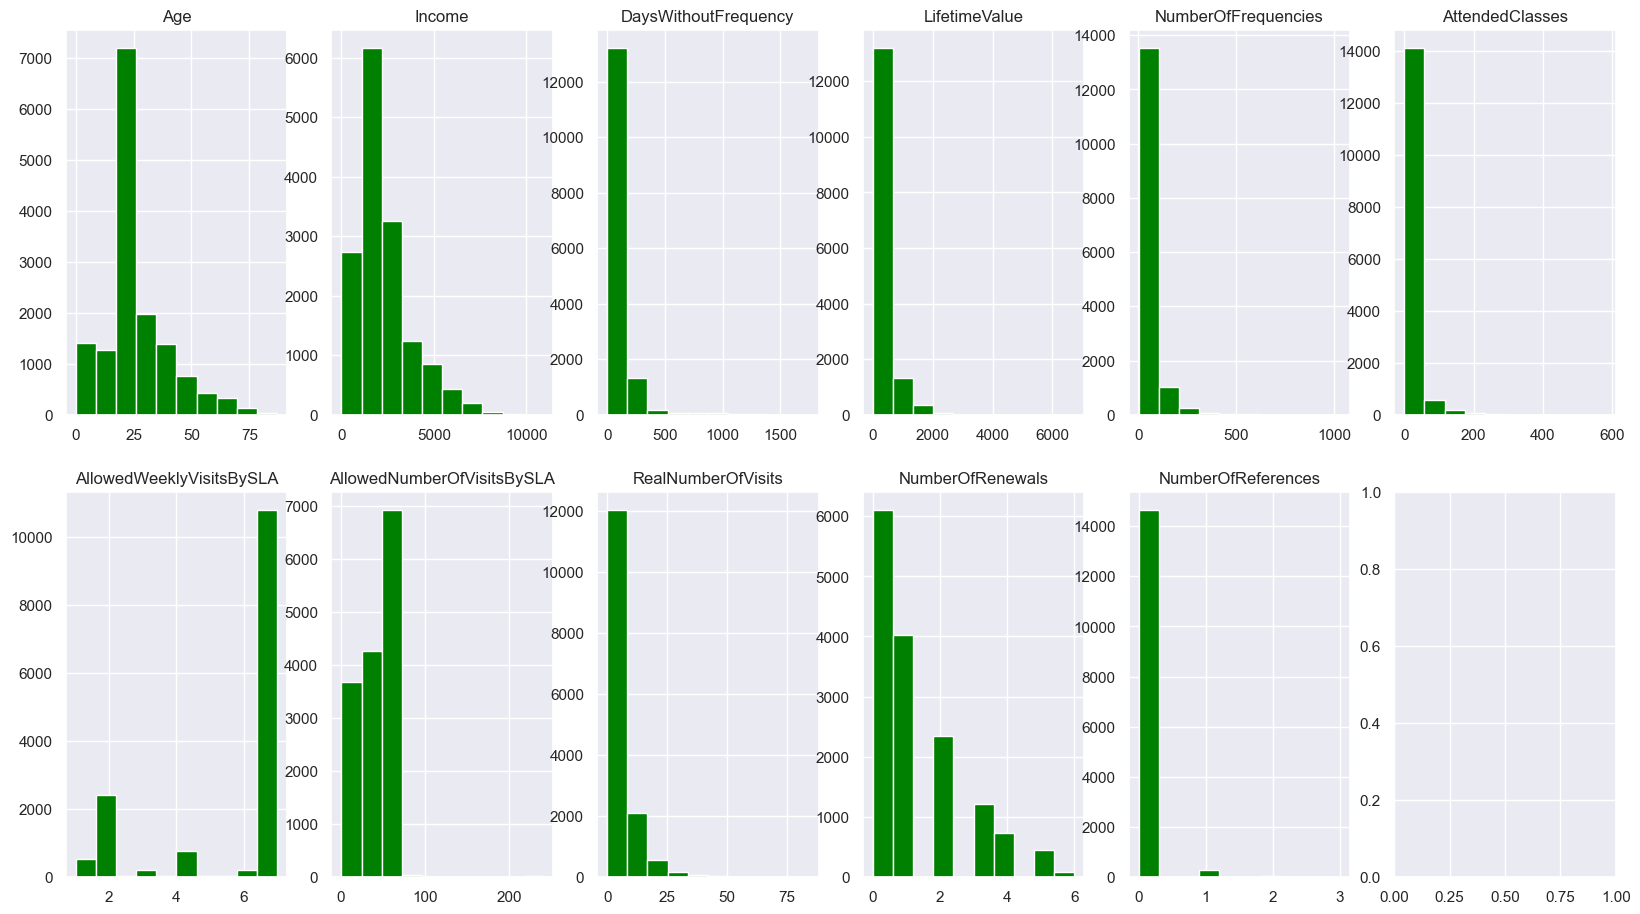

In [24]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram
for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(df[feat], color = 'green')
    ax.set_title(feat)

plt.show()

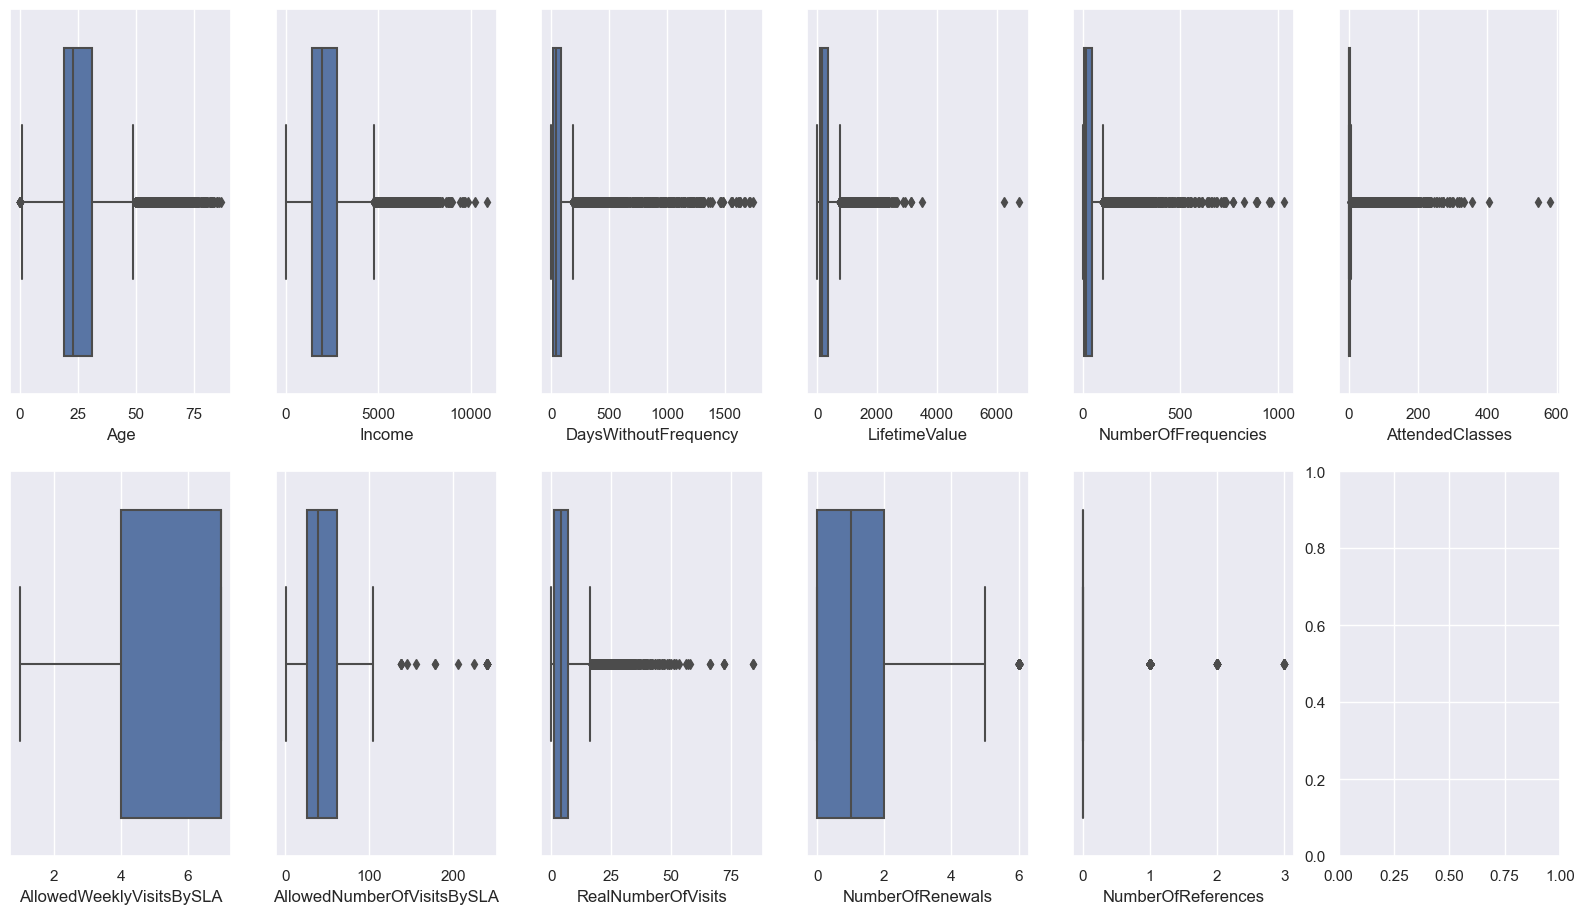

In [25]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax)
    
plt.show()

__Pairwise Relationship of Numerical Variables__

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
findfont: score(FontEntry(fname='C:\\Users\\maria\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\maria\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\maria\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\maria\\anaconda3\\envs\\DM2324\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymBol

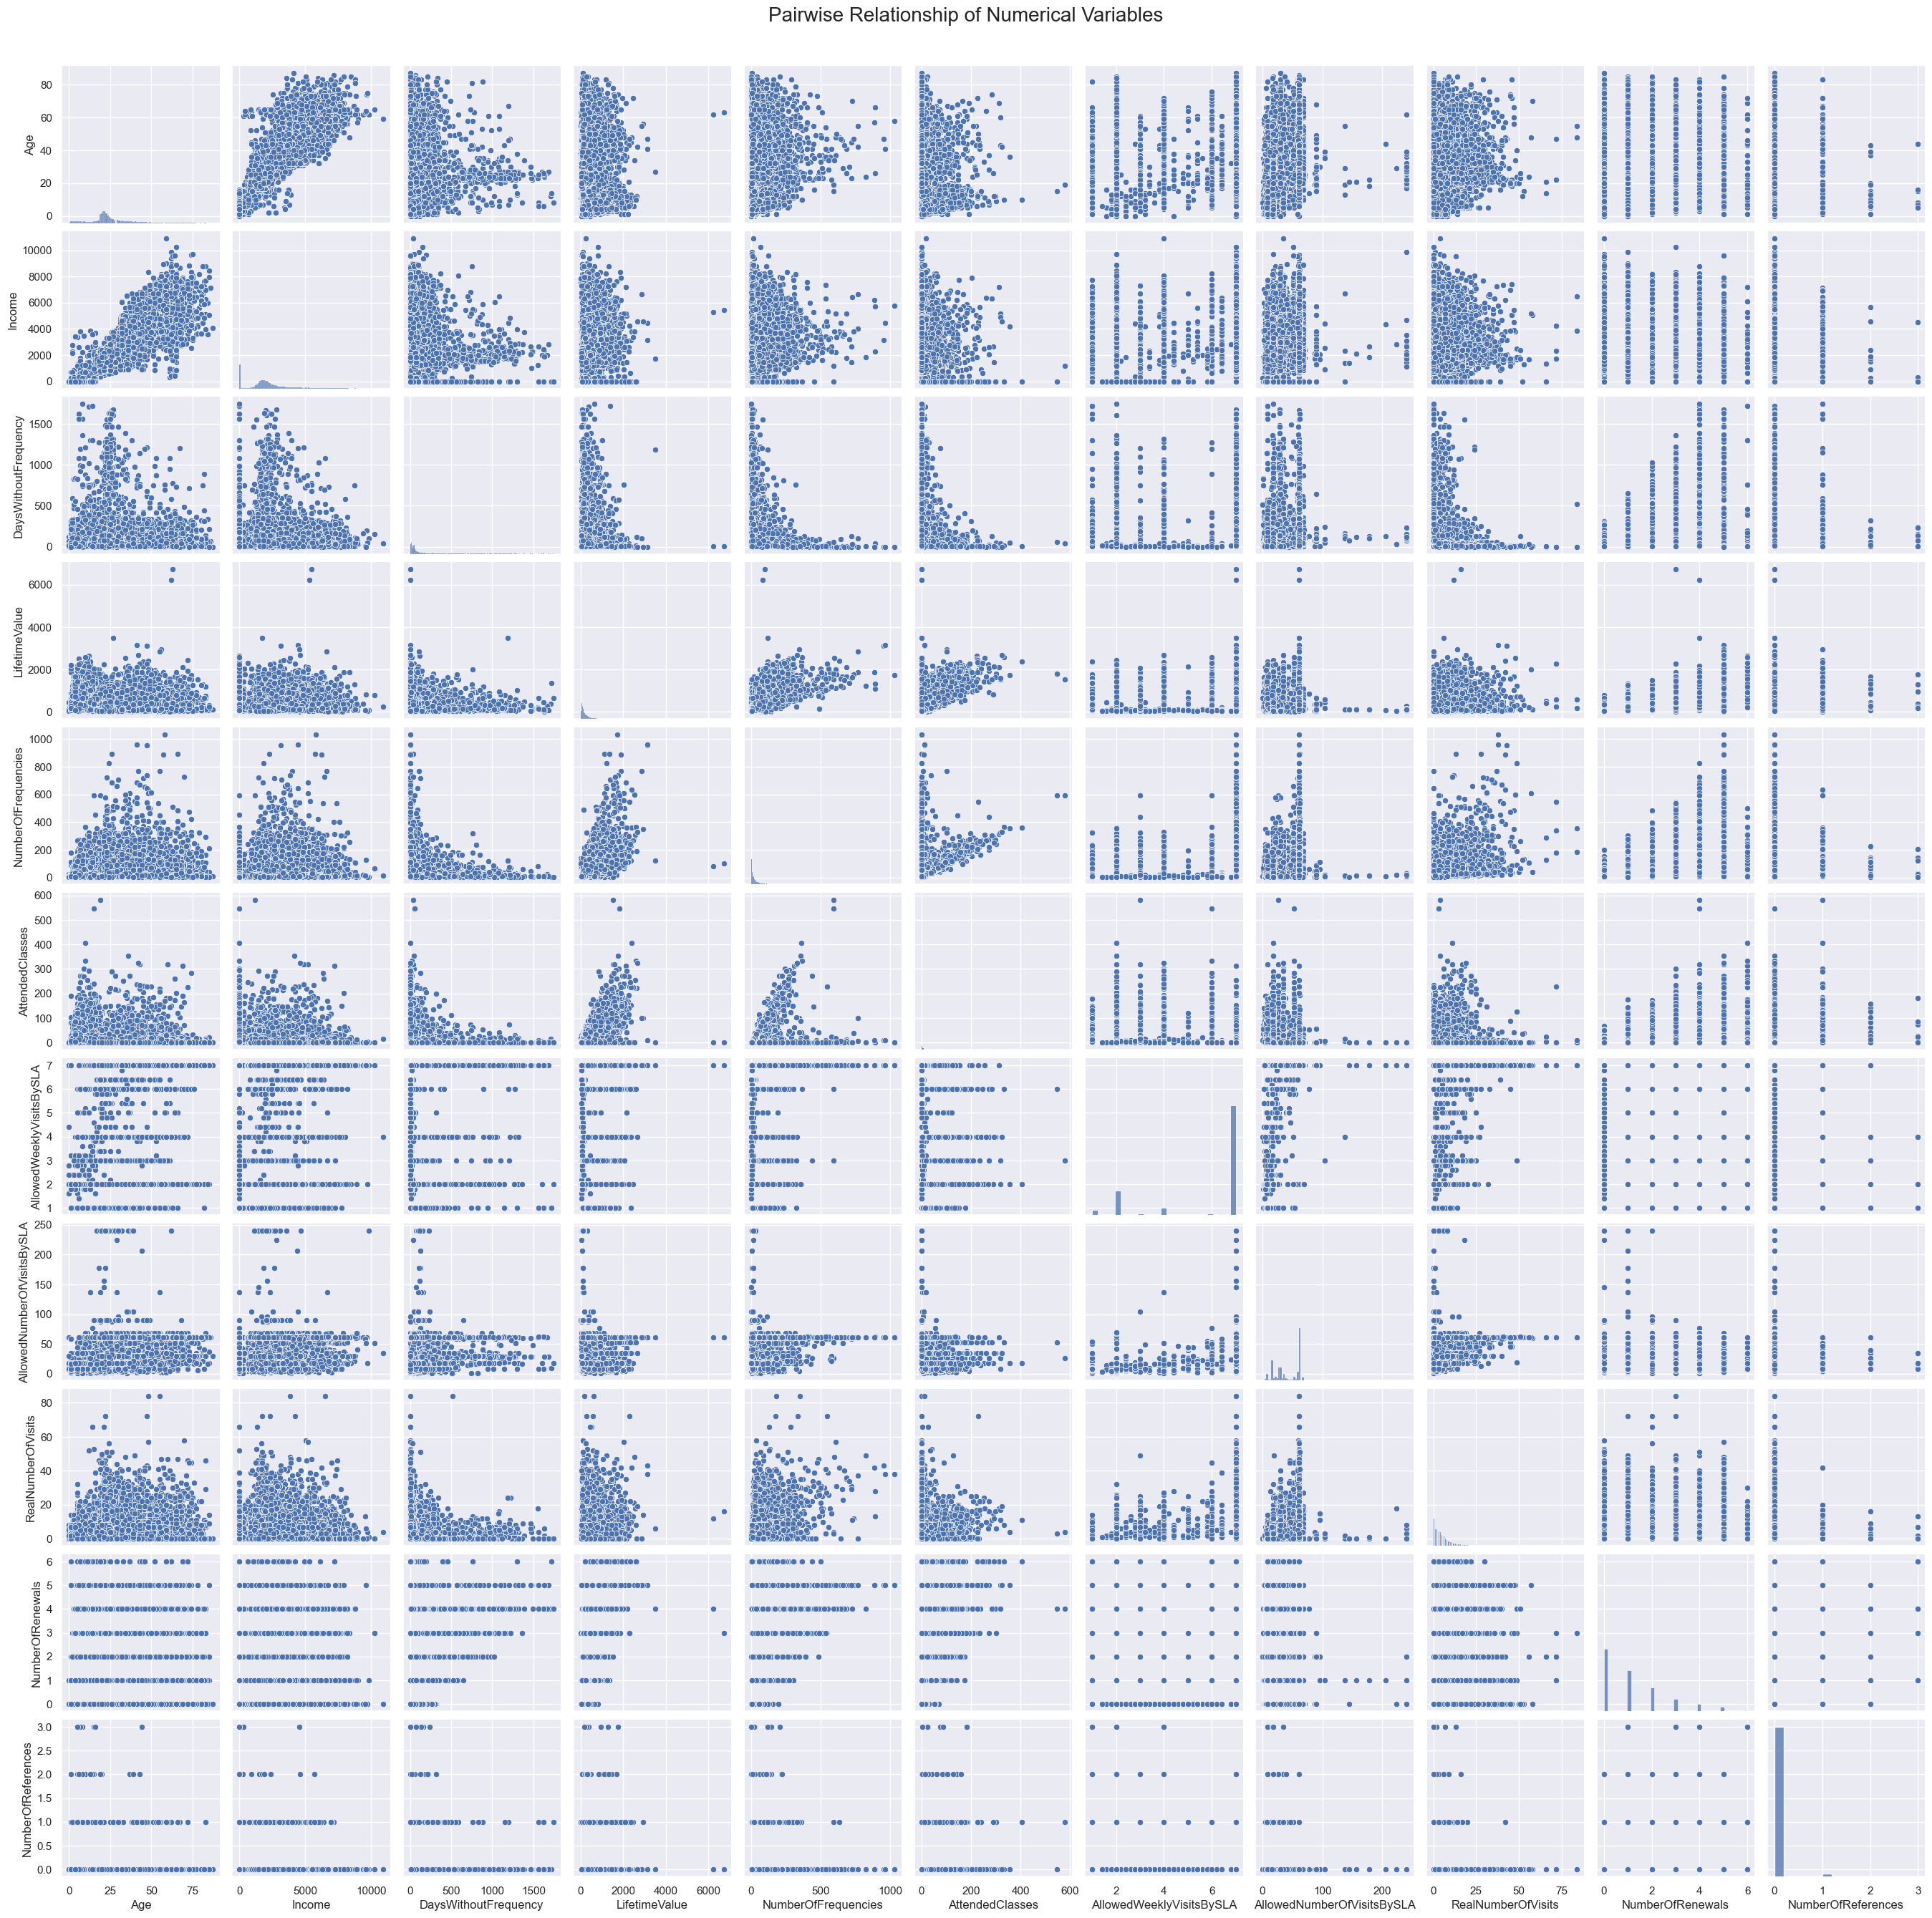

In [26]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(df[metric_features], diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

if not os.path.exists(os.path.join('..', 'figures', 'exp_analysis')):
    # if the exp_analysis directory is not present then create it first
    os.makedirs(os.path.join('..', 'figures', 'exp_analysis'))

plt.show()

__Metric Variables' Correlation Matrix__

locator: <matplotlib.ticker.AutoLocator object at 0x00000238A5AED1D0>


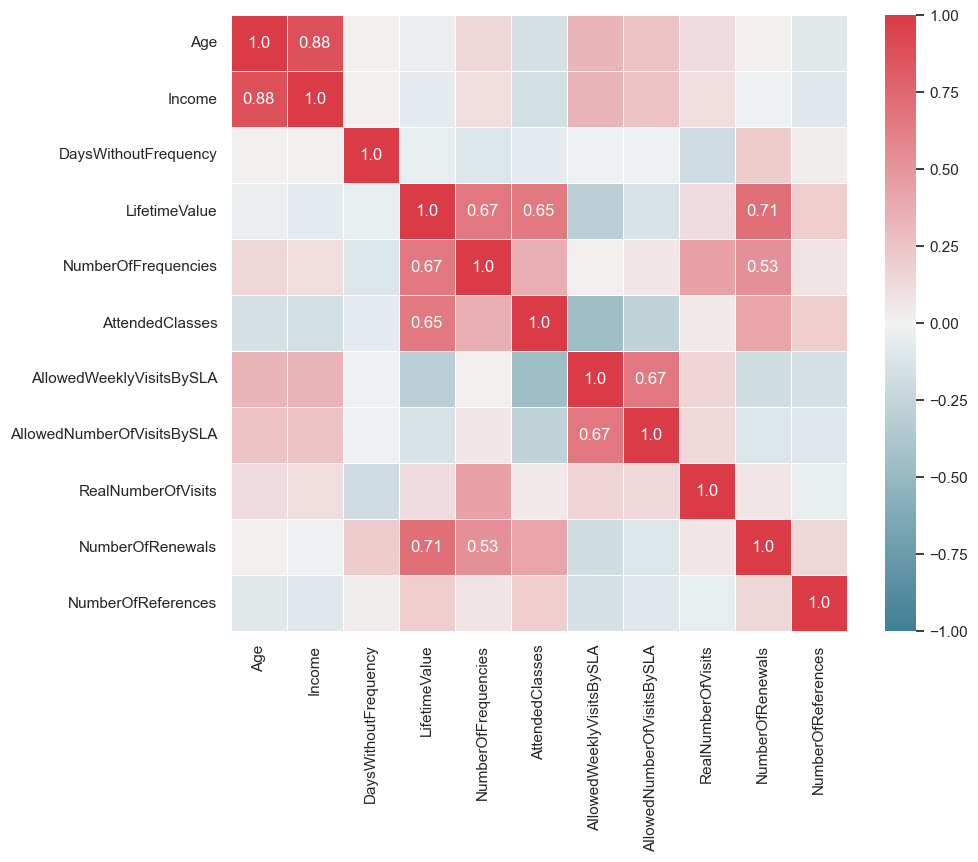

In [27]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.show()

### Treating Outliers

### Scaling

In [28]:
df_minmax = df.copy()

In [29]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
df_minmax[metric_features] = scaler.fit_transform(df_minmax[metric_features])

In [30]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.data_min_, "\n", scaler.data_max_)

Parameters fitted:
 [0.   0.   0.   0.   1.   0.   1.   0.56 0.   0.   0.  ] 
 [8.7000e+01 1.0890e+04 1.7450e+03 6.7278e+03 1.0310e+03 5.8100e+02
 7.0000e+00 2.4003e+02 8.4000e+01 6.0000e+00 3.0000e+00]


In [31]:
df_minmax.head()

,Age,Gender,Income,EnrollmentStart,EnrollmentFinish,LastPeriodStart,LastPeriodFinish,DateLastVisit,DaysWithoutFrequency,LifetimeValue,...,OtherActivities,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisitsBySLA,AllowedNumberOfVisitsBySLA,RealNumberOfVisits,NumberOfRenewals,HasReferences,NumberOfReferences,Dropout
0,0.689655,0,0.505051,2019-09-03,2019-10-31,2019-07-01,2019-12-31,2019-10-30,0.000573,0.013281,...,0,0.007767,0.012048,0.833333,0.023886,0.023810,0.000000,0,0.0,0
1,0.333333,0,0.241506,2014-08-12,2015-09-14,2015-01-01,2015-12-31,2015-07-16,0.034384,0.071227,...,0,0.021359,0.001721,0.166667,0.070405,0.011905,0.333333,0,0.0,1
2,0.264368,1,0.181818,2017-05-02,2017-06-01,2017-01-01,2017-06-30,2017-05-25,0.004011,0.005589,...,0,0.004854,0.000000,1.000000,0.123063,0.071429,0.000000,0,0.0,1
3,0.103448,1,0.000000,2018-09-05,2019-02-12,2018-07-01,2019-06-30,2019-01-21,0.012607,0.023098,...,0,0.018447,0.003442,0.166667,0.071658,0.035714,0.000000,0,0.0,1
4,0.402299,1,0.396694,2016-04-20,2018-06-07,2018-01-01,2018-06-30,2017-11-09,0.120344,0.055471,...,0,0.038835,0.000000,1.000000,0.252265,0.000000,0.500000,0,0.0,1
